In [1]:
from datasets import load_dataset
data = load_dataset("../data/20230419_224x224/", cache_dir="~/cache")

Found cached dataset 20230419_224x224 (/home2/shubh/cache/20230419_224x224/first_domain/1.1.0/09ca5b8cc58d1d3ba6ea901ee6712e987b511b5da6e12fc36863d53a37c994e7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [1]:
from datasets import load_dataset
data = load_dataset("cifar10", cache_dir="/pscratch/sd/s/shubh/")

Found cached dataset cifar10 (/pscratch/sd/s/shubh/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
# id2label = {id:label for id, label in enumerate(data["train"].features) if label != "map"}
id2label = {id:label for id, label in enumerate(["Om", "s8"])}
label2id = {label:id for id,label in id2label.items()}
id2label, label2id

({0: 'Om', 1: 's8'}, {'Om': 0, 's8': 1})

In [2]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [3]:
import numpy as np
data

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
from transformers import AutoImageProcessor, ViTForImageClassification, ViTConfig, ViTModel

checkpoint = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(checkpoint, # num_labels=2, \
            # problem_type = "regression", 
            id2label=id2label, label2id=label2id,
            num_channels=3, image_size=224, patch_size=16, ignore_mismatched_sizes=True)

print(model.config.problem_type)
print(model.config.num_labels)

model

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


None
10


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image
import torch

size = (224, 224)

print(size)

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=0, std=1)

train_data_augmentation = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            normalize,
        ]
    )

val_data_augmentation = Compose(
        [
            Resize(size),
            normalize,
        ]
    )

def preprocess_train(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    # examples["labels"] = np.transpose([examples[x] for x in ["Om", "s8"]]).astype(np.float32)
    examples['pixel_values'] = [train_data_augmentation(torch.swapaxes(torch.Tensor(np.array(image)), 0, 2)) for image in examples['img']]
    return examples

def preprocess_val(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    # examples["labels"] = np.transpose([examples[x] for x in ["Om", "s8"]]).astype(np.float32)
    examples['pixel_values'] = [val_data_augmentation(torch.swapaxes(torch.Tensor(np.array(image)), 0, 2)) for image in examples['img']]
    return examples

data["train"].set_transform(preprocess_train)
# data["validation"].set_transform(preprocess_val)
data["test"].set_transform(preprocess_val)

(224, 224)


In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(data["train"], collate_fn=collate_fn, batch_size=4)

In [8]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="~/cache/my_awesome_food_model",
    remove_unused_columns=False,
    # evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    # per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0,
    logging_steps=10,
    # load_best_model_at_end=True,
    # metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=data["test"],
)

trainer.train()

Step,Training Loss
10,1.765000
20,1.761800
30,1.720500
40,1.720500
50,1.690000
60,1.699700
70,1.696200
80,1.678600
90,1.656900
100,1.620300


/global/cfs/cdirs/des/shubh/.conda/envs/vit/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/global/cfs/cdirs/des/shubh/.conda/envs/vit/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

TrainOutput(global_step=468, training_loss=1.511860688527425, metrics={'train_runtime': 280.9546, 'train_samples_per_second': 106.779, 'train_steps_per_second': 1.666, 'total_flos': 2.321206494920442e+18, 'train_loss': 1.511860688527425, 'epoch': 3.0})

In [17]:
test_dataloader = DataLoader(data["test"], collate_fn=collate_fn, batch_size=4)

In [18]:
output = model(torch.cat(list(map(lambda x: (x.unsqueeze(0)).to("cuda"), test_dataloader.dataset[0:10]["pixel_values"]))), 
               output_attentions=True)

In [19]:
for ind in range(10):
    predicted_label = output["logits"][ind].argmax(-1).item()
    print(ind, id2label[str(predicted_label)], predicted_label, id2label[str(test_dataloader.dataset[ind]["label"])])

0 cat 3 cat
1 ship 8 ship
2 ship 8 ship
3 ship 8 airplane
4 deer 4 frog
5 frog 6 frog
6 automobile 1 automobile
7 horse 7 frog
8 dog 5 cat
9 truck 9 automobile


airplane


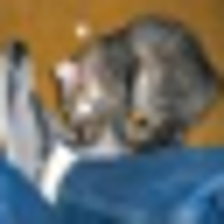

In [20]:
print(id2label[str(train_dataloader.dataset[0]["label"])])
test_dataloader.dataset[0]["img"].resize((224, 224))

In [15]:
output["attentions"][0][0].shape

torch.Size([12, 197, 197])

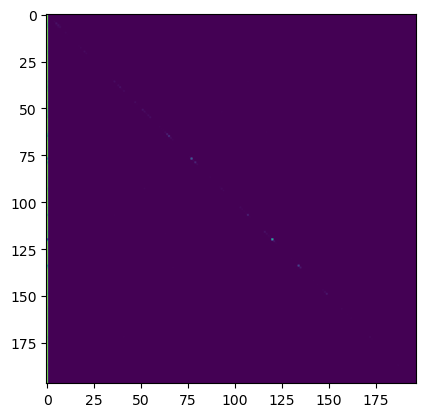

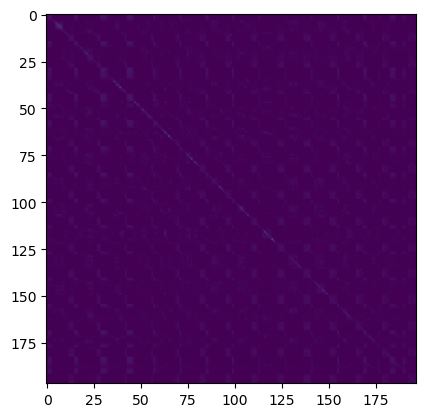

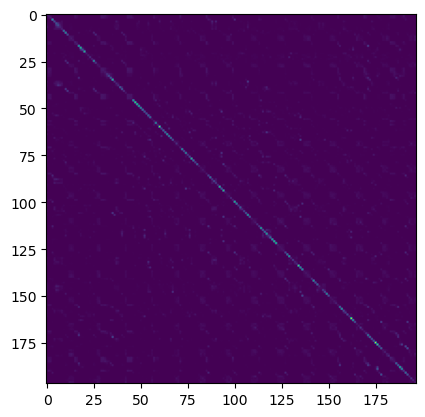

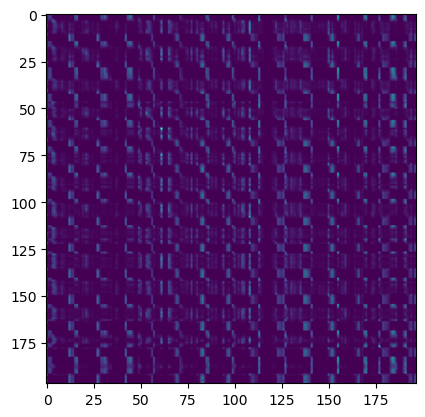

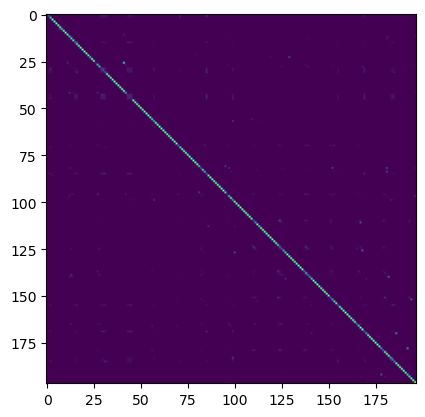

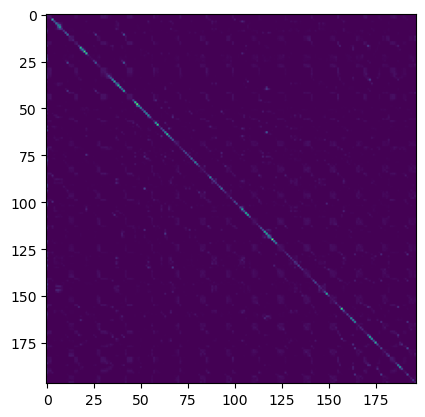

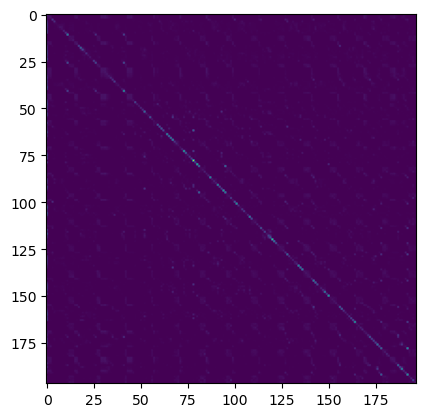

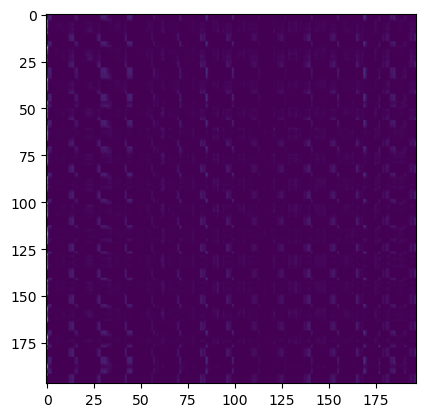

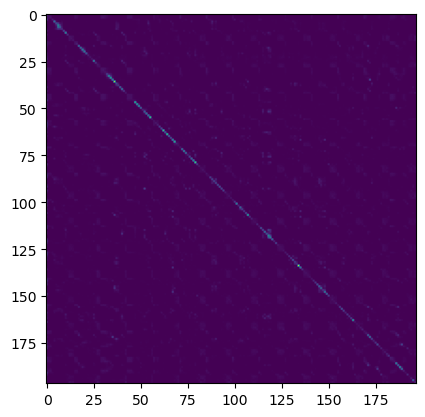

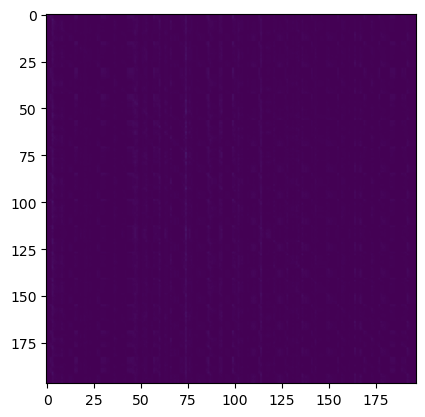

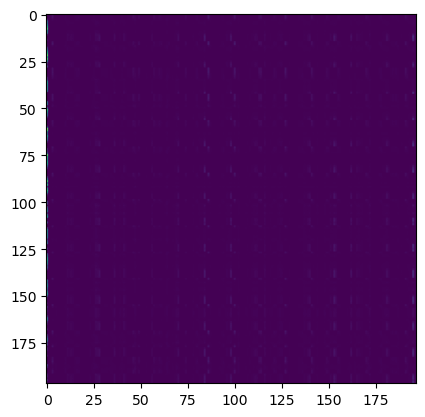

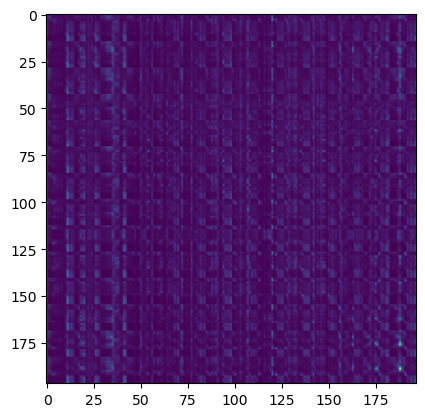

In [22]:
for i in range(12):
    plt.figure()
    plt.imshow(output["attentions"][0][0][i].cpu().detach().numpy())
    plt.show()
    plt.close()

In [15]:
import sys
sys.path.append("../../vit-explain/")

In [19]:
import vit_rollout
from importlib import reload
reload(vit_rollout)

rollout = vit_rollout.VITAttentionRollout(model, discard_ratio=0.9)
mask = rollout(torch.cat(list(map(lambda x: x.unsqueeze(0), train_dataloader.dataset[0:1]["pixel_values"]))))

In [23]:
np.array(train_dataloader.dataset[0]["image"]).shape

/home2/shubh/.conda/envs/vit/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(512, 384, 3)

In [24]:
output = model(torch.cat(list(map(lambda x: x.unsqueeze(0).to("cuda"), train_dataloader.dataset[0:1]["pixel_values"]))), 
               output_attentions=True)

In [96]:
output.attentions[0].shape

torch.Size([1, 12, 197, 197])

In [87]:
import cv2

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

np_img = np.array(train_dataloader.dataset[0]["image"])[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
cv2.imshow("Input Image", np_img)
# cv2.imshow(name, mask)
cv2.imwrite("input.png", np_img)
# cv2.imwrite(name, mask)
cv2.waitKey(-1)

KeyError: 'image'

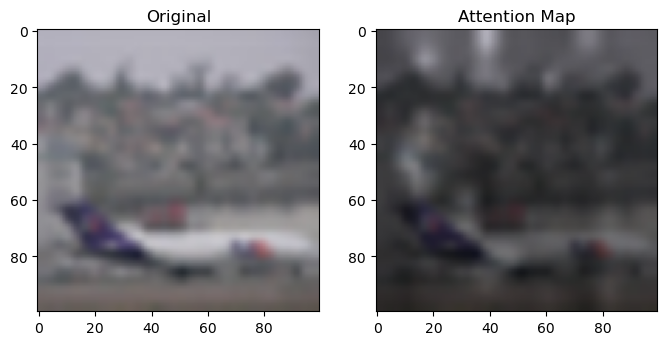

Prediction Label and Attention Map!

0.45143 : ship
0.31620 : airplane
0.06878 : automobile
0.03796 : truck
0.03122 : bird
0 ship 8 airplane


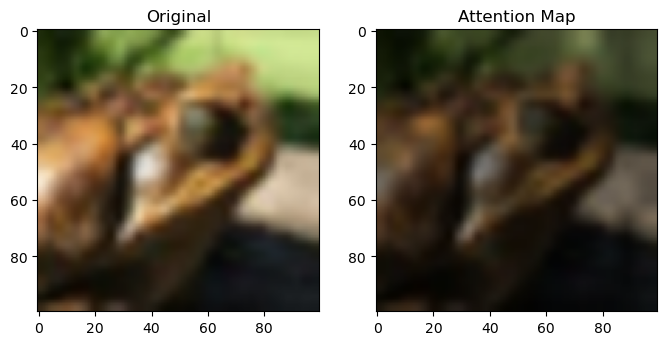

Prediction Label and Attention Map!

0.30278 : frog
0.21796 : deer
0.12045 : bird
0.10425 : dog
0.10374 : cat
1 frog 6 frog


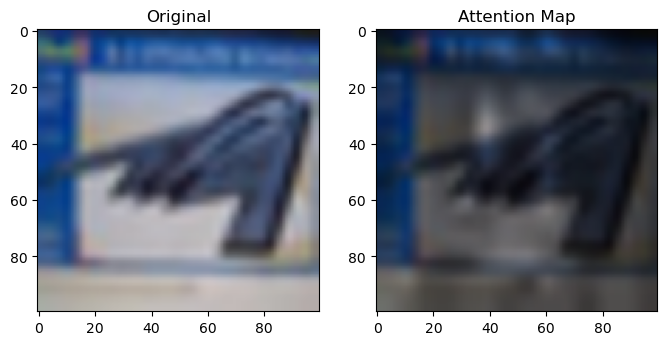

Prediction Label and Attention Map!

0.41256 : automobile
0.21709 : truck
0.15741 : airplane
0.09326 : ship
0.02539 : deer
2 automobile 1 airplane


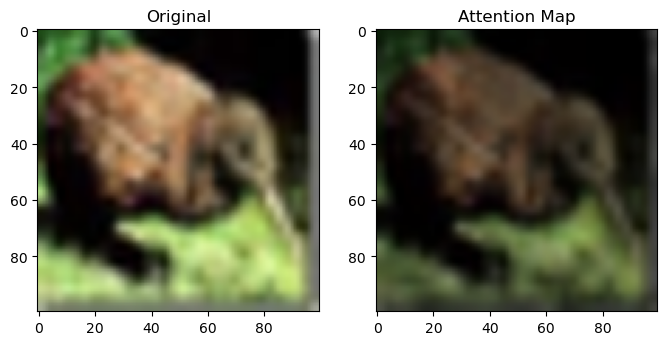

Prediction Label and Attention Map!

0.33607 : frog
0.27015 : deer
0.11316 : bird
0.10581 : horse
0.05756 : dog
3 frog 6 bird


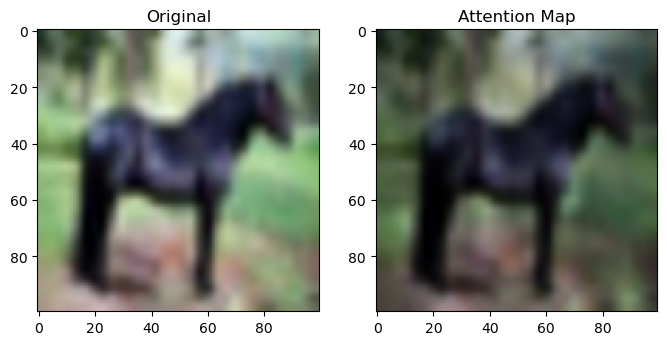

Prediction Label and Attention Map!

0.38486 : horse
0.21030 : dog
0.12300 : deer
0.09357 : cat
0.06724 : bird
4 horse 7 horse


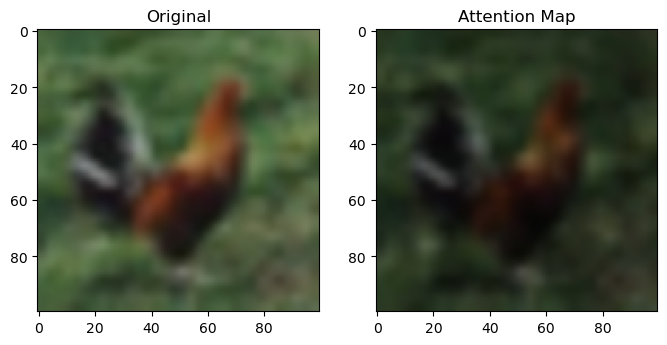

Prediction Label and Attention Map!

0.50366 : deer
0.14432 : bird
0.10680 : horse
0.08575 : frog
0.06529 : dog
5 deer 4 bird


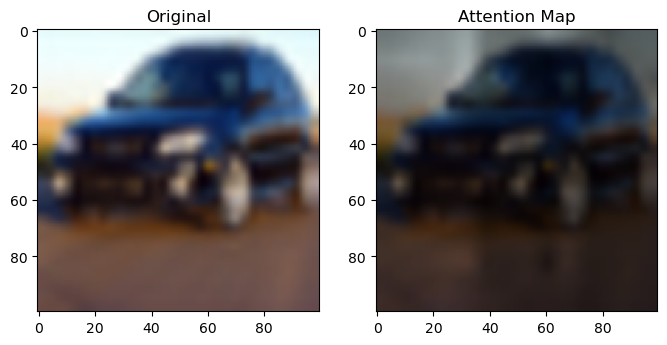

Prediction Label and Attention Map!

0.37091 : automobile
0.14671 : cat
0.12179 : truck
0.07968 : dog
0.05590 : ship
6 automobile 1 automobile


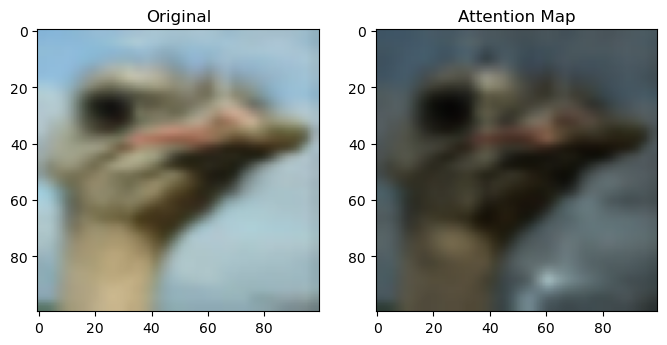

Prediction Label and Attention Map!

0.40145 : ship
0.21955 : airplane
0.13666 : bird
0.05133 : cat
0.04867 : deer
7 ship 8 bird


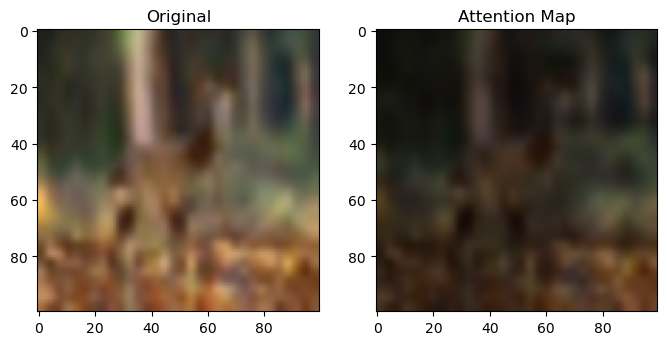

Prediction Label and Attention Map!

0.33615 : deer
0.15362 : cat
0.15162 : dog
0.14878 : frog
0.09908 : bird
8 deer 4 deer


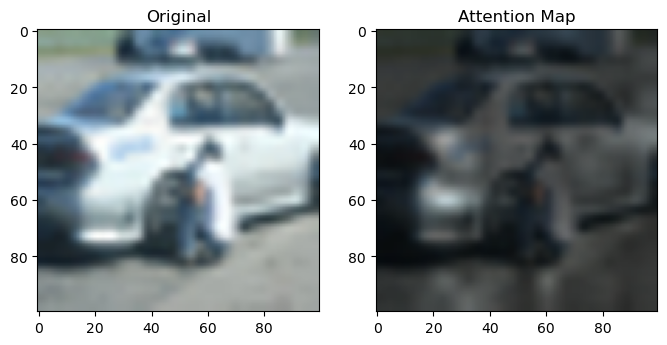

Prediction Label and Attention Map!

0.35851 : automobile
0.21596 : ship
0.19798 : truck
0.12844 : airplane
0.02270 : cat
9 automobile 1 automobile


In [29]:
import cv2

for ind in range(10):

    output = model(torch.cat(list(map(lambda x: x.unsqueeze(0).to("cuda"), train_dataloader.dataset[ind:ind+1]["pixel_values"]))), 
                output_attentions=True)

    att_mat = torch.stack(output["attentions"]).squeeze(1).cpu()

    im = train_dataloader.dataset[ind]["img"]

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1)).cpu()
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(im.resize((100, 100)))
    _ = ax2.imshow(Image.fromarray(result).resize((100, 100)))

    plt.show()
    plt.close()

    probs = torch.nn.Softmax(dim=-1)(output["logits"])
    top5 = torch.argsort(probs, dim=-1, descending=True)
    print("Prediction Label and Attention Map!\n")
    for idx in top5[0, :5]:
        print(f'{probs[0, idx.item()]:.5f} : {id2label[str(idx.item())]}')
    predicted_label = output["logits"].argmax(-1).item()
    print(ind, id2label[str(predicted_label)], predicted_label, id2label[str(train_dataloader.dataset[ind]["label"])])